### Логистическая регрессия
Имеются данные adult.csv (см. в материалах к занятию)

Целевой переменной является уровень дохода income (крайний правый столбец).

Описание признаков можно найти по [ссылке](http://www.cs.toronto.edu/~delve/data/adult/adultDetail.html)

Вам необходимо построить модель логистической регрессии, которая предсказывает уровень дохода человека. При возможности попробуйте улучшить точность предсказаний (метод score) с помощью перебора признаков.

In [46]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [47]:
adult = pd.read_csv('/home/data/netology_ml/data/hw 3 (log reg)/adult.csv')

### 1. Познакомимся с данными

In [48]:
adult.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [49]:
adult.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


Похоже, что пропущенные категориальные переменные заменены на "?", а непрерывные на "999". Дальше будем думать, что с ними делать.

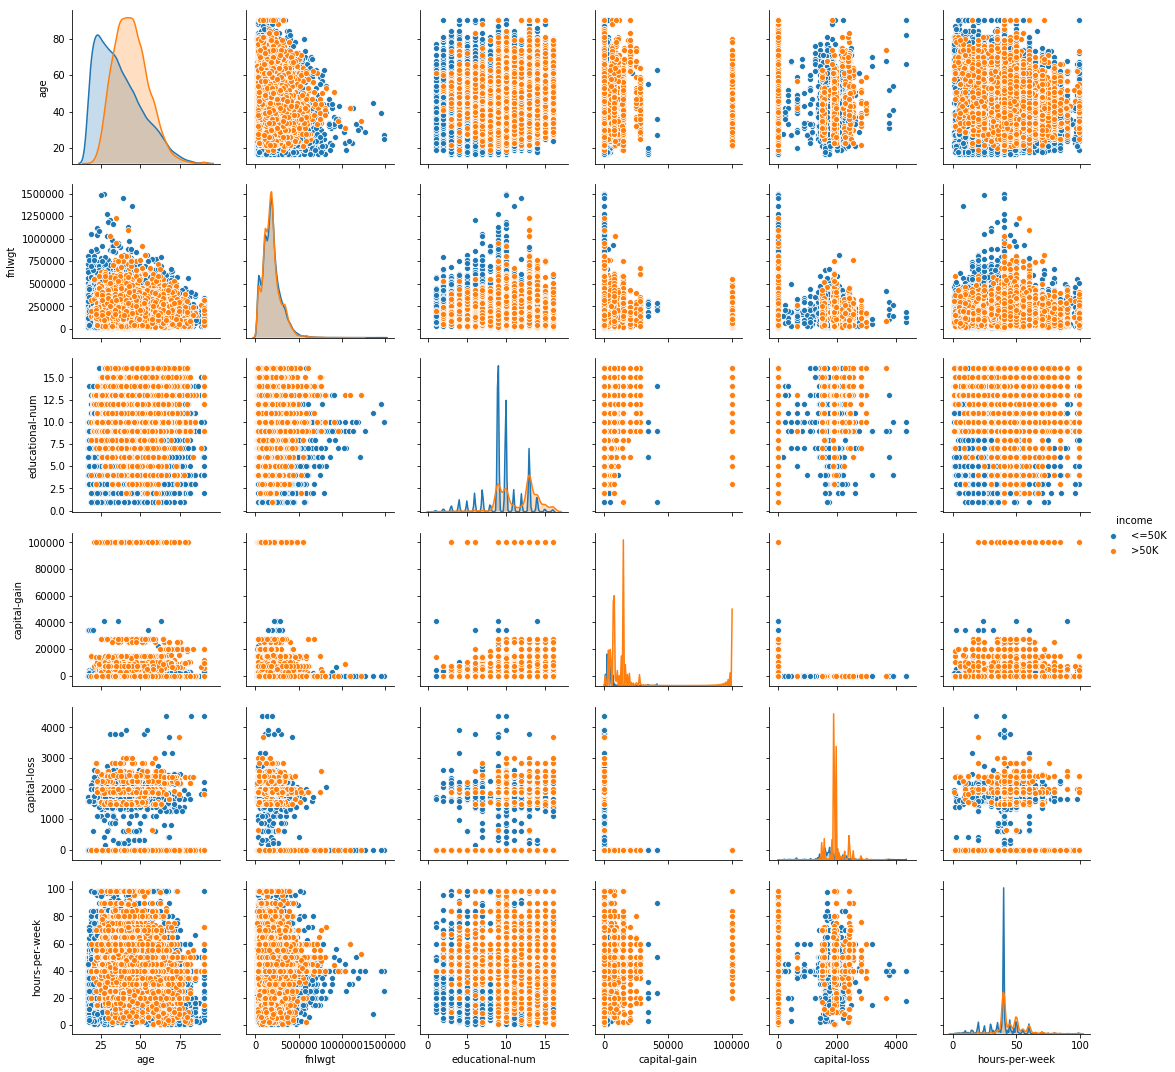

In [50]:
sns.pairplot(adult, hue='income')

In [51]:
for each in adult.columns:
    if adult[each].dtype == 'O':
        print(adult[each].value_counts(), '\n')

Private             33906
Self-emp-not-inc     3862
Local-gov            3136
?                    2799
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64 

HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: education, dtype: int64 

Married-civ-spouse       22379
Never-married            16117
Divorced                  6633
Separated                 1530
Widowed                   1518
Married-spouse-absent      628
Married-AF-spouse           37
Name: marital-status, dtype: int64 

Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-clerical      

Если верить описанию датасета, то в нем 7% пропущенных значений.
Посмотрим, какие результаты дает решение задачи "в лоб", а потом попробуем по-умному заполнить пропуски.

### 2. Решаем задачу в лоб: Строим логрегрессию на "грязных данных"

In [52]:
le_income = LabelEncoder()
adult.income = le_income.fit_transform(adult.income)

In [53]:
scaler = StandardScaler()
for each in adult.columns:
    if adult[each].dtype != 'O' and each != 'income':
        adult[each] = scaler.fit_transform(np.reshape(adult[each].tolist(), (-1, 1)))

In [54]:
adult = pd.get_dummies(adult, dummy_na=False)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(adult.drop(columns='income'), adult.income, test_size=0.3, random_state=42)

In [73]:
lr_stupid = LogisticRegression(random_state=42)
lr_stupid.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [77]:
print('Train accuracy: ', metrics.accuracy_score(lr_stupid.predict(X_train), y_train),
'\nTest accuracy: ', metrics.accuracy_score(lr_stupid.predict(X_test), y_test))

Train accuracy:  0.8517944368071602 
Test accuracy:  0.857503582884051


In [78]:
def draw_roc(x_train, y_train, x_test, y_test, model, model_name):
    sns.set(font_scale=1.2)
    sns.set_color_codes("muted")
    
    fpr_train, tpr_train, _ = metrics.roc_curve(y_train, model.predict_proba(x_train)[:,1])
    fpr_test, tpr_test, _ = metrics.roc_curve(y_test, model.predict_proba(x_test)[:,1])
    
    auc_train = metrics.roc_auc_score(y_train, model.predict(x_train))
    auc_test = metrics.roc_auc_score(y_test, model.predict(x_test))
    
    plt.plot(fpr_train, tpr_train, label=model_name+" train auc="+str(round(auc_train, 5)))
    plt.plot(fpr_test,tpr_test,label=model_name+" test auc="+str(round(auc_test, 5)))
    
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0,1], [0,1], linestyle='--')
    plt.legend(loc=4)
    plt.show()

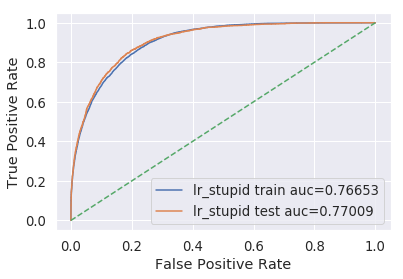

In [92]:
draw_roc(X_train, y_train, X_test, y_test, lr_stupid, 'lr_stupid')

Первый раз получаю результат на тесте больше чем на обучающей выборке.

### 3. Займеся пропущенными значениями

Сперва посмотрим как распределена целевая переменная в группах со знаком ?, затем заменим все пропущенные значения на NAN.

In [81]:
adult_inspect = pd.read_csv('/home/data/netology_ml/data/hw 3 (log reg)/adult.csv')

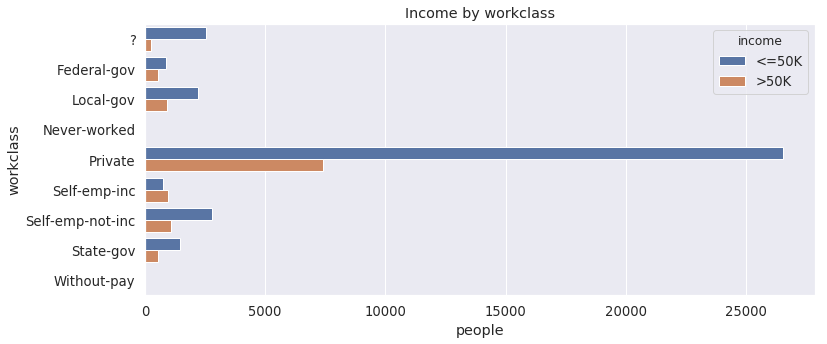

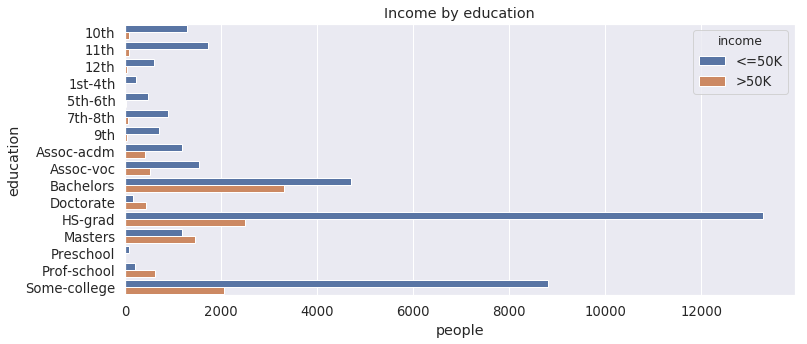

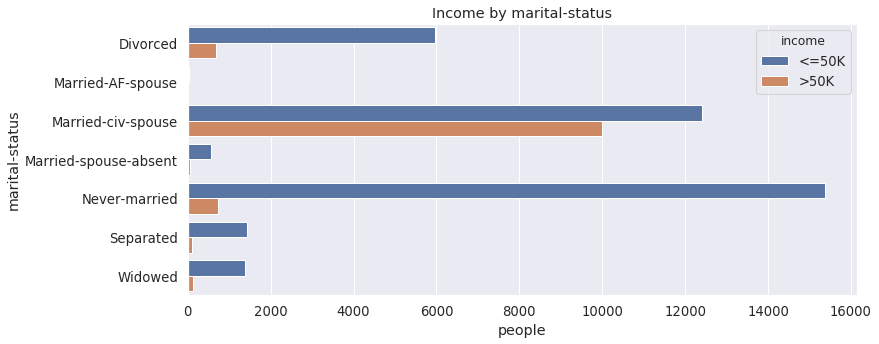

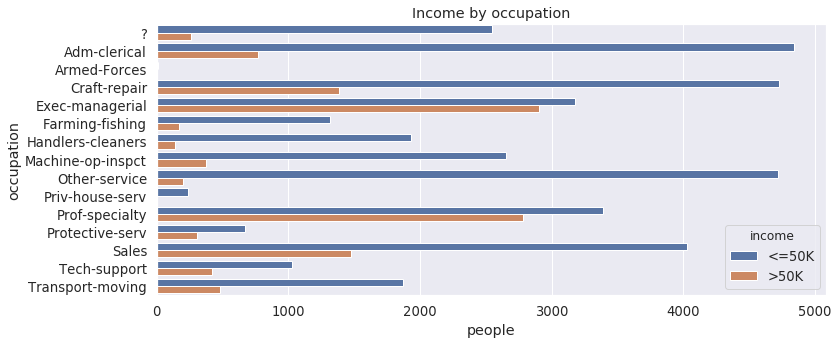

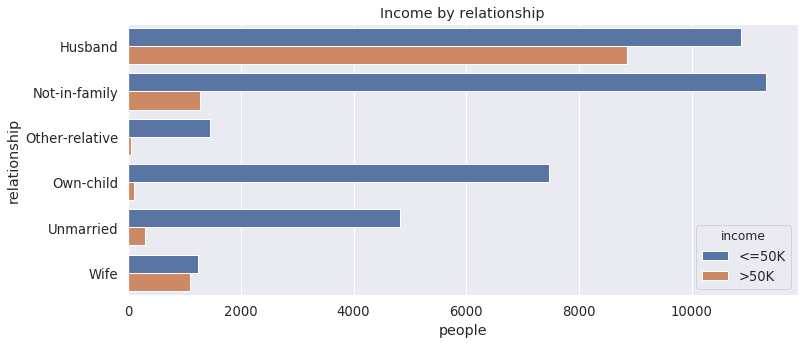

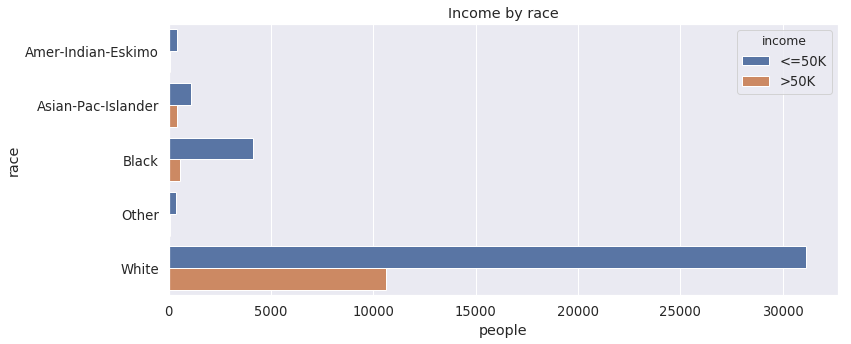

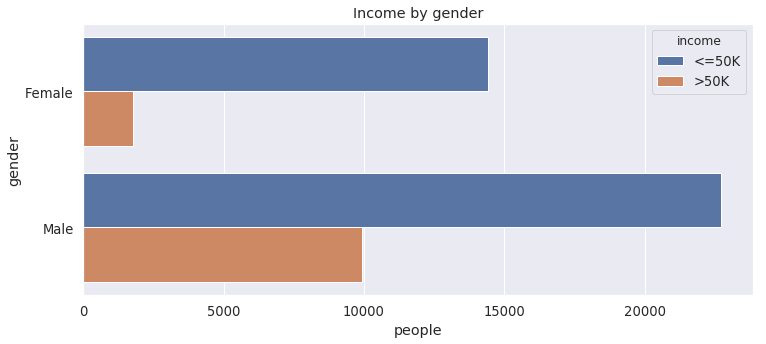

In [84]:
for each in adult_inspect.columns:
    if adult_inspect[each].dtype == 'O' and each != 'native-country' and each != 'income':
        fig, ax = plt.subplots(figsize=(12,5))
        plt_data = adult_inspect.groupby(by=[each, 'income']).count().reset_index()
        sns.barplot(x='age', y=each, hue='income' , data=plt_data).set_title('Income by '+each)
        ax.set(xlabel='people')
        plt.show()

Изучил распределение целевой переменной в группах с пропущенными значениям и решил оставить их как есть.

In [85]:
#for each in adult.columns:
#    if adult[each].dtype == 'O':
#        adult[each] = adult.apply(lambda x: float('nan') if x[each] == '?' else x[each], axis=1)
#adult.info()

### 4. Попробуем использовать GridSearch для поиска оптимальных параметров модели.

In [86]:
lr_clever = LogisticRegression()

grid = {'penalty': ['l1', 'l2'],
        'tol': [0.00001, 0.0001, 0.001, 0.01, 0.0005],
        'C': [0.001, 0.01, 0.1, 1, 10],
        'fit_intercept': [False, True]
        }

gridsearch = GridSearchCV(lr_clever, grid, scoring='roc_auc', cv=3, n_jobs=-1)

In [87]:
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'tol': [1e-05, 0.0001, 0.001, 0.01, 0.0005], 'C': [0.001, 0.01, 0.1, 1, 10], 'fit_intercept': [False, True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [88]:
gridsearch.best_params_

{'C': 0.1, 'fit_intercept': True, 'penalty': 'l2', 'tol': 0.001}

In [93]:
lr_clever = LogisticRegression(C=0.1, fit_intercept=True, penalty='l2', tol=0.001)
lr_clever.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.001,
          verbose=0, warm_start=False)

In [94]:
print('Train accuracy: ', metrics.accuracy_score(lr_clever.predict(X_train), y_train),
'\nTest accuracy: ', metrics.accuracy_score(lr_clever.predict(X_test), y_test))

Train accuracy:  0.8508292140747024 
Test accuracy:  0.8574353374735549


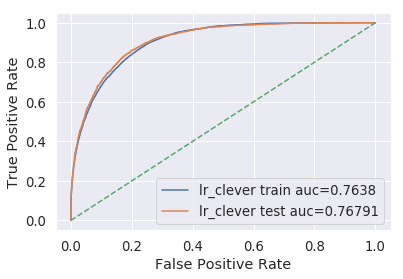

In [95]:
draw_roc(X_train, y_train, X_test, y_test, lr_clever, 'lr_clever')

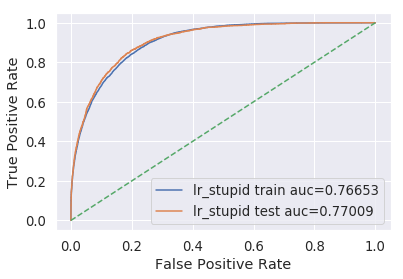

In [96]:
draw_roc(X_train, y_train, X_test, y_test, lr_stupid, 'lr_stupid')

Прогон данных через GridSearch не дал результатов и даже ухудшил качество модели